In [1]:
# Calculate efflux-reflux between two cross-sections
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import gsw
import cmocean
import Functions as fun
import os, sys

In [2]:
# Input file info
#path1 = '/work/oceans/wbao/MITgcm_results/jorgemontt/Qsg150_wind'
path1 = '/Volumes/T7 Shield/MITgcm_jorgemontt/Qsg150_wind/'
path2 = '/Volumes/T7 Shield/MITgcm_jorgemontt/Qsg150_rep_wind/'
taum1 = np.array([-0.2, -0.1, 0, 0.1, 0.2, -0.3, -0.4, 0.3, 0.4, -0.8, 0.8, -1.5, 1.5]) # maximum wind stress (single event)
taum2 = np.array([-0.2, -0.1, 0.1, 0.2, -0.3, -0.4, 0.3, 0.4, -0.8, 0.8]) # maximum wind stress (repeated events)

# No-Tide
path3 = '/Volumes/T7 Shield/MITgcm_jorgemontt/Qsg150_Wind1_S/' # Single wind event with sill
path4 = '/Volumes/T7 Shield/MITgcm_jorgemontt/Qsg150_Wind4_S/' # Single wind event with sill
path5 = '/Volumes/T7 Shield/MITgcm_jorgemontt/Qsg150_Wind30_S/' # Persistent wind for 30d
taum3 = np.array([0, 0.1, 0.3, -0.1, -0.3, 0.9, 1.5, -0.9, -1.5]) # maximum wind stress (single event)
taum4 = np.array([0.1, 0.3, 0.9, 1.5, -0.1, -0.3, -0.9, -1.5]) # maximum wind stress (4 repeated events)
# taum5 = np.array([0, -1.5, -0.9, -0.3, -0.1, 0.1, 0.3, 0.9, 1.5])
taum5 = [0, 0.1, 0.3, 0.9, 1.5, -0.1, -0.3, -0.9, -1.5]

xrange = np.array([0,97]) # X index range for the segment between glacier and outer sill
xsill = 95
x1, x2 = 60, 70 # Inner sill
x3, x4 = 90, 100 # Outer sill

# Indexes for down-/up-fjord wind
# down_case1 = [3,4,5,8,9,11,13]
# up_case1 = [2,1,6,7,10,12]

# down_case2 = [3,4,7,8,10]
# up_case2 = [2,1,5,6,9]

In [ ]:
np.argsort(taum3)+1

In [ ]:
# No-wind case
dist, depth, time, temp, sal, den, u, w = fun.along_fjord_state(path3,1)

In [ ]:
time[-21:]/86400

In [ ]:
# Show the location of segments
# Plot along-fjord velocity, temperature, and salinity
fig0, ax = plt.subplots(1,1, figsize=(12,3))

# Time-mean (60~90d)
U, Temp, Sal, RhoA = u.mean(0), temp.mean(0), sal.mean(0), den.mean(0)-1000
mask = (temp[0,:,:] == 0)
U[mask] = np.nan
Temp[mask] = np.nan
Sal[mask] = np.nan
RhoA[mask] = np.nan

cr_u = np.linspace(-0.15,0.15,20) # Contour range
cr_t = np.linspace(4,9,20)
cr_s = np.linspace(20,32,20)
cr_rho = np.linspace(1017,1027,6)-1000

# Along-fjord velocity
im1 = ax.contourf(dist, depth, U, cr_u, cmap=cmocean.cm.balance)
# Add cross-sections
ax.axvline(x=dist[x1], color='b',lw=2)
ax.axvline(x=dist[x2], color='b',lw=2)
ax.axvline(x=dist[x3], color='b',lw=2)
ax.axvline(x=dist[x4], color='b',lw=2)
#ax1.axhline(y=-50, color='b',lw=2)
CS1 = ax.contour(dist, depth,RhoA,cr_rho, colors='k', linewidths=.5)
plt.clabel(CS1, fontsize=12, inline=1)

cbar1 = fig0.colorbar(im1,ax=ax)
cbar1.set_ticks([-0.15, -0.1,-0.05,0,0.05,0.1,0.15])
cbar1.set_label('Velocity [$m/s$]', size=15)

ax.set_facecolor('grey')
ax.tick_params(direction='in', labelsize=15)
#ax1.xaxis.set_visible(False)
ax.set_xlim([dist[0],40])
# ax1.set_xticks([X[0], 10, 20, 30, X[-1]])
ax.set_yticks([depth[0], -100, -200, -300, depth[-1]])
ax.set_yticklabels(["0","-100","-200","-300","-400"])
ax.set_ylabel('Depth [$m$]', size=15)
ax.set_xlabel('Distance from glacier [$km$]', size=15)
#ax1.set_title(r'(a)', loc='left', size=15, weight='bold')
ax.annotate('Glacier', xy=(3,25), xytext=(7,29), 
            xycoords='data', arrowprops=dict(facecolor='black',width=1), fontsize=15, annotation_clip=False)


## TEF and Efflux-Reflux

In [9]:
# TEF transports at each cross-section
#caseid = 13
#qin1, qout1, sin1, sout1 = fun.tef_transport(path1,caseid,x1)
#qin2, qout2, sin2, sout2 = fun.tef_transport(path1,caseid,x2)
# qin3, qout3, sin3, sout3 = fun.tef_transport(path1,caseid,x3)
# qin4, qout4, sin4, sout4 = fun.tef_transport(path1,caseid,x4)

# Single Wind
Qin3_w1 = []
Qout3_w1 = []
Sin3_w1 = []
Sout3_w1 = []
Qin4_w1 = []
Qout4_w1 = []
Sin4_w1 = []
Sout4_w1 = []
for i in np.argsort(taum3)+1:
#for i in [6,5,0,1,2]: # tau= -0.3, -0.1, 0, 0.1, 0.3
    qin3, qout3, sin3, sout3 = fun.tef_transport(path3,i,x3)
    qin4, qout4, sin4, sout4 = fun.tef_transport(path3,i,x4)
    Qin3_w1.append(qin3)
    Qout3_w1.append(qout3)
    Sin3_w1.append(sin3)
    Sout3_w1.append(sout3)
    Qin4_w1.append(qin4)
    Qout4_w1.append(qout4)
    Sin4_w1.append(sin4)
    Sout4_w1.append(sout4)


  time 0 out of 121
  time 0 out of 121
  time 0 out of 121
  time 0 out of 121
  time 0 out of 121
  time 0 out of 121
  time 0 out of 121
  time 0 out of 121
  time 0 out of 121
  time 0 out of 121
  time 0 out of 121
  time 0 out of 121
  time 0 out of 121
  time 0 out of 121
  time 0 out of 121
  time 0 out of 121
  time 0 out of 121
  time 0 out of 121


In [ ]:
# Repeated Wind
Qin3_w4 = []
Qout3_w4 = []
Sin3_w4 = []
Sout3_w4 = []
Qin4_w4 = []
Qout4_w4 = []
Sin4_w4 = []
Sout4_w4 = []
for j in np.argsort(taum4)+2:
    qin3, qout3, sin3, sout3 = fun.tef_transport(path4,j,x3)
    qin4, qout4, sin4, sout4 = fun.tef_transport(path4,j,x4)
    Qin3_w4.append(qin3)
    Qout3_w4.append(qout3)
    Sin3_w4.append(sin3)
    Sout3_w4.append(sout3)
    Qin4_w4.append(qin4)
    Qout4_w4.append(qout4)
    Sin4_w4.append(sin4)
    Sout4_w4.append(sout4)

In [13]:
taum = [-1.5,-0.9,-0.3,-0.1,0,0.1,0.3,0.9,1.5]
# taum = [-1.5,-0.9,-0.3,-0.1,0.1,0.3,0.9,1.5]
# taum = [-0.3,-0.1,0,0.1,0.3]
tt = -21 # Day 85

alpha_w1 = []
alpha_up = []
Qr_w1 = []
Qin1 = []
Qin2 = []
Qout1 = []
Qout2 = []
for k in range(len(taum)):
    Qin1.append(Qin3_w1[k][tt:].mean())
    Qin2.append(Qin4_w1[k][tt:].mean())
    Qout1.append(Qout3_w1[k][tt:].mean())
    Qout2.append(Qout4_w1[k][tt:].mean())
    Qin_w1 = [Qin3_w1[k][tt:].mean(), Qin4_w1[k][tt:].mean()]
    Qout_w1 = [Qout3_w1[k][tt:].mean(), Qout4_w1[k][tt:].mean()]
    Sin_w1 = [Sin3_w1[k][tt:].mean(), Sin4_w1[k][tt:].mean()]
    Sout_w1 = [Sout3_w1[k][tt:].mean(), Sout4_w1[k][tt:].mean()]
    X = fun.efflux_reflux(Qin_w1, Qout_w1, Sin_w1, Sout_w1, error=False)
    alpha_w1.append(X[0][-1])
    alpha_up.append(X[0][0])
    Qr_w1.append(X[1]-X[2])


# alpha_w4 = []
# Qr_w4 = []
# for k in range(len(taum)-1):
#     Qin_w4 = [Qin3_w4[k][tt:].mean(), Qin4_w4[k][tt:].mean()]
#     Qout_w4 = [Qout3_w4[k][tt:].mean(), Qout4_w4[k][tt:].mean()]
#     Sin_w4 = [Sin3_w4[k][tt:].mean(), Sin4_w4[k][tt:].mean()]
#     Sout_w4 = [Sout3_w4[k][tt:].mean(), Sout4_w4[k][tt:].mean()]
#     X = fun.efflux_reflux(Qin_w4, Qout_w4, Sin_w4, Sout_w4, error=False)
#     alpha_w4.append(X[0][-1])
#     Qr_w4.append(X[1]-X[2])

In [7]:
np.array(Qin1)-np.array(Qin2), (np.array(Qin1)-np.array(Qin2))/np.array(Qin1)

(array([3124.53668402, 5121.89756268, 3286.0509613 , 2179.71656574,
        7817.72295797]),
 array([0.42343847, 0.44627647, 0.42990822, 0.33319111, 0.54943419]))

In [ ]:
alpha_w1, alpha_w4, Qr_w1, Qr_w4

In [ ]:
#qin1[:25], qout1[:25]
len(time), time[-121]/86400
#Q = fun.filt_godin(qin1)
#Q[-121:]

In [ ]:
from scipy.interpolate import interp1d, InterpolatedUnivariateSpline
not_nan = ~np.isnan(sout4)
L = np.arange(len(sout4))

# Linear Interpolation
linear_interpolator = interp1d(L[not_nan], sout4[not_nan], kind='linear', bounds_error=False)
linear_interpolated = linear_interpolator(np.arange(len(sout4)))

# Spline Interpolation
spline_interpolator = InterpolatedUnivariateSpline(L[not_nan], sout4[not_nan])
spline_interpolated = spline_interpolator(np.arange(len(sout4)))


# Nearest Interpolation
nearest_interpolator = interp1d(L[not_nan], sout4[not_nan], kind='nearest', fill_value="extrapolate")
nearest_interpolated = nearest_interpolator(np.arange(len(sout4)))

In [ ]:
#%matplotlib widget
%matplotlib inline
fig1 = plt.figure(figsize=(8,3), tight_layout=True)    
ax1 = fig1.add_subplot(111)


plt.grid(linestyle = '--', linewidth = 0.5)

#ax1.plot(time/86400,sout3,lw=2,label=r'Sout3')
ax1.plot(time/86400,sout4,lw=2,label=r'Sout4')
#ax1.plot(time/86400,linear_interpolated,lw=2,label=r'Linear')
#ax1.plot(time/86400,spline_interpolated,lw=2,label=r'Spline')
ax1.plot(time/86400,nearest_interpolated,lw=2,label=r'Nearest')

ax1.legend(loc='upper right',fontsize=12)
ax1.set(xlim=(60, 90), ylim=(27, 30))
ax1.tick_params(direction='in', labelsize=12)
ax1.set_xlabel('Days',fontsize=12)
ax1.set_ylabel(r'$S_{out}$',fontsize=12)


In [ ]:
# Linear Interpolation
from scipy.interpolate import interp1d
not_nan1 = ~np.isnan(sout4)
L = np.arange(len(sout4))
fun_interp1 = interp1d(L[not_nan1], sout4[not_nan1], kind='linear', bounds_error=False)
sout4_interp = fun_interp1(np.arange(len(sout4)))

not_nan2 = ~np.isnan(sin4)
fun_interp2 = interp1d(L[not_nan2], sin4[not_nan2], kind='linear', bounds_error=False)
sin4_interp = fun_interp2(np.arange(len(sin4)))

In [ ]:
# Average over the last 5 days of simulation
tt = -121 # starting time

# # Segment 1 (Inner sill)
# Qin1 = [np.nanmean(fun.filt_godin(qin1)[tt:]), np.nanmean(fun.filt_godin(qin2)[tt:])]
# Qout1 = [np.nanmean(fun.filt_godin(qout1)[tt:]), np.nanmean(fun.filt_godin(qout2)[tt:])]
# Sin1 = [np.nanmean(fun.filt_godin(sin1)[tt:]), np.nanmean(fun.filt_godin(sin2)[tt:])]
# Sout1 = [np.nanmean(fun.filt_godin(sout1)[tt:]), np.nanmean(fun.filt_godin(sout2)[tt:])]

# Segment 2 (Outer sill)
Qin2 = [np.nanmean(fun.filt_godin(qin3)[tt:]), np.nanmean(fun.filt_godin(qin4)[tt:])]
Qout2 = [np.nanmean(fun.filt_godin(qout3)[tt:]), np.nanmean(fun.filt_godin(qout4)[tt:])]
Sin2 = [np.nanmean(fun.filt_godin(sin3)[tt:]), np.nanmean(fun.filt_godin(sin4_interp)[tt:])]
Sout2 = [np.nanmean(fun.filt_godin(sout3)[tt:]), np.nanmean(fun.filt_godin(sout4_interp)[tt:])]

In [ ]:
# a11, a01, a10, a00
#alpha1 = fun.efflux_reflux(Qin1, Qout1, Sin1, Sout1, error=True)
alpha2 = fun.efflux_reflux(Qin2, Qout2, Sin2, Sout2, error=True)

In [ ]:
alpha2, alpha2[0][-1]*alpha2[1], alpha2[1]-alpha2[2]

In [18]:
alpha_w1, Qr_w1

([0.22113323498052362,
  0.22451867178789187,
  0.22617337199685209,
  0.2284173283533173,
  0.23609959645538098,
  0.23750595599749852,
  0.2554557844094935,
  0.24626535701468366,
  0.24379053452081897],
 [3471.3767581926995,
  3480.486337346554,
  3499.742545624724,
  3429.909529097078,
  3436.00783701404,
  3425.2324820418526,
  3494.8755483404257,
  3583.7401482943933,
  3625.5710393205973])

In [21]:
## For Record
# Tau = [0, 0.1, 0.2, 0.3, 0.4, 0.8, 1.5]
# a11 = [-0.126, -0.126, -0.125, -0.126, -0.127, -0.132, 0.006]
# a00 = [0.218, 0.218, 0.223, 0.226, 0.231, 0.252, 0.368]
# Qe = [1737, 1747, 1793, 1826, 1883, 2102, 3106]
taum = [-1.5, -0.9, -0.3, -0.1, 0, 0.1, 0.3, 0.9, 1.5]
a11 = [0.221, 0.225, 0.226, 0.228, 0.236, 0.238, 0.255, 0.246, 0.244]
Qe = [3471.4, 3480.5, 3499.7, 3429.9, 3436.0, 3425.2, 3494.9, 3583.7, 3625.6]
taum_sub = [-0.3, -0.1, 0, 0.1, 0.3]
a11_sub = [0.226, 0.228, 0.236, 0.238, 0.255]
Qe_sub = [3499.7, 3429.9, 3436.0, 3425.2, 3494.9] # For tau=-0.3,-0.1,0,0.1,0.3
lr = np.polyfit([-0.1,0,0.3],[3429.9, 3436.0, 3494.9], 1) # Linear regression
Qe_adj = lr[0]*np.array([-0.3,0.1])+lr[1]
print(Qe_adj)
Qr_new = [3391.2, 3429.9, 3436.0, 3459.3, 3494.9]

[3391.15384615 3459.27692308]


In [ ]:
fig2 = plt.figure(figsize=(5,4), tight_layout=True)    

ax1 = fig2.add_subplot(111)
#plt.axis('square')
plt.grid(linestyle = '--', linewidth = 0.5)
ax1.plot(Tau,[alpha * 100 for alpha in a00],'v-g',ms=8,label=r'$\alpha_{11}$')
# #eflx[eflx<0] = 0
# ax3.plot(hsr,a22,'^-g',ms=10,label=r'$\alpha_{22}$')
#ax1.legend(bbox_to_anchor=(.65,.75), fontsize=15)
#ax1.set(xlim=(0, 2), ylim=(0.2,0.4))
ax1.set(ylim=(20,40))
ax1.tick_params(direction='in', labelsize=12)
ax1.tick_params(axis='y', colors='green')

#ax3.set_xticks([0.04, 0.06, 0.08, 0.10, 0.12])
ax1.set_xlabel(r"$\tau_x$ [$N\,m^{-2}$]",fontsize=12)
ax1.set_ylabel(r"Reflux Coefficient (%)",fontsize=12,color='g')
#ax3.set_title('(b)', loc='left', size=15, weight='bold')

ax2=ax1.twinx()
ax2.plot(Tau,Qe,'o-r',ms=8,label=r'$Q_r$')
ax2.set(ylim=(1300,3300))
#ax4.legend(loc='right', fontsize=15)
ax2.tick_params(direction='in', labelsize=12)
ax2.spines['left'].set_color('green')
ax2.spines['right'].set_color('red')
ax2.tick_params(axis='y', colors='red')
#ax4.set_ylim([1, 9])
#ax4.set_yticks([1.5, 3, 4.5, 6, 7.5, 9])
ax2.set_ylabel(r"Downward reflux $[m^3\,s^{-1}]$",fontsize=12,color='r')

Text(0, 0.5, 'Downward reflux $[m^3\\,s^{-1}]$')

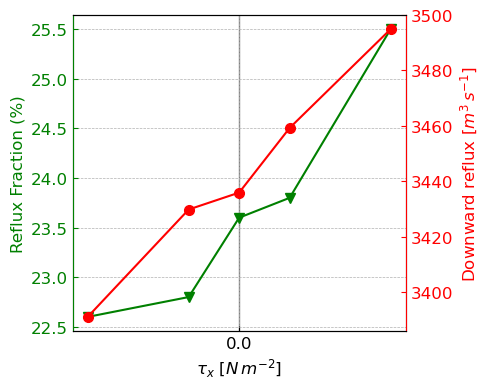

In [22]:
fig3 = plt.figure(figsize=(5,4), tight_layout=True)    

ax1 = fig3.add_subplot(111)
#plt.axis('square')
plt.grid(linestyle = '--', linewidth = 0.5)
#ax1.plot(taum,[alpha * 100 for alpha in alpha_w1],'v-g',ms=7,label=r'$\alpha_{11}$',zorder=2)
ax1.plot(taum_sub,[alpha * 100 for alpha in a11_sub],'v-g',ms=7,label=r'$\alpha_{11}$',zorder=2)
ax1.axvline(x=0, color='grey',ls='-',lw=1,zorder=1)
#ax1.set(xlim=(0, 2), ylim=(0.2,0.4))
#ax1.set(ylim=(20,28))
ax1.tick_params(direction='in', labelsize=12)
ax1.tick_params(axis='y', colors='green')

ax1.set_xticks([-1.5,-1,-0.5,0,0.5,1,1.5])
ax1.set_xlabel(r"$\tau_x$ [$N\,m^{-2}$]",fontsize=12)
ax1.set_ylabel(r"Reflux Fraction (%)",fontsize=12,color='g')
#ax3.set_title('(b)', loc='left', size=15, weight='bold')

ax2=ax1.twinx()
#ax2.plot(taum,Qr_w1,'o-r',ms=7,label=r'$Q_r$',zorder=2)
ax2.plot(taum_sub,Qr_new,'o-r',ms=7,label=r'$Q_r$',zorder=2)
#ax2.set(ylim=(3200,3800))
ax2.tick_params(direction='in', labelsize=12)
ax2.spines['left'].set_color('green')
ax2.spines['right'].set_color('red')
ax2.tick_params(axis='y', colors='red')
ax2.set_ylabel(r"Downward reflux $[m^3\,s^{-1}]$",fontsize=12,color='r')

In [24]:
def VolFlux(datapath, case_id, xid):
    # Calculate along-fjord volume fluxes at cross-section xid
    State0 = xr.open_dataset(datapath+'state_' + str(format(case_id,'03d')) + '.nc')
    State = State0.isel(T=~State0.get_index("T").duplicated())
    Grid = xr.open_dataset(datapath+'grid.nc')

    state = State.isel(X=slice(200), Xp1=slice(201), Y=slice(35,45))
    grid = Grid.isel(X=slice(200), Xp1=slice(201), Y=slice(35,45))  
    
    time = state.T.data / 86400

    area = grid.drF * grid.dyF * grid.HFacC
    U = (state.U.data[:,:,:,1:] + state.U.data[:,:,:,:-1]) / 2
    Qp = np.empty(len(time))
    Ql = np.empty(len(time))
    for t in range(len(time)):
        Q = U[t,:,:,xid] * area.data[:,:,xid]
        Qp[t] = Q[Q > 0].sum()
        # last_positive_id = np.where(Q.mean(1) > 0)[0][-1]
        # Ql[t] = Q[last_positive_id:,:].sum()
    
        # Find the index of the last positive value in each column using a masked array
        masked_positives = np.ma.masked_array(Q, mask=Q <= 0)
        last_positive_indices = np.ma.argmax(masked_positives, axis=0)

        # Initialize a total sum of lower-layer negatives
        total_sum_lower_negatives = 0

        # Calculate the sum for each column based on the last positive index
        for col in range(Q.shape[1]):
        # Adjust for columns where the maximum index is 0 but it's actually a negative value
            if Q[0, col] > 0 or np.max(masked_positives[:, col]) > 0:
                index = last_positive_indices[col] + 1
            else:
                index = 0  # If no positive values, start from the beginning
            Ql[t] += np.sum(Q[index:, col][Q[index:, col] < 0])
    
    return time, Qp, Ql

In [25]:

xsill = 95
Qls = [] # lower layer volume flux with sill
Ql = [] # lower layer volume flux without sill

for i in np.argsort(taum3)+1:
    time, Qp1, Ql1 = VolFlux(path3,i,xsill)
    #time, Qp2, Ql2 = VolFlux(path2,i,xsill) 
    Qls.append(Ql1[:13].mean())

Ql_wind30 = [] # Under continuous wind
for j in [6,5,1,2]:
    time, Qp30, Ql30 = VolFlux(path5,j,xsill)
    Ql_wind30.append(Ql30[-21:].mean())

Text(0.5, 0, '$\\tau_x$ [$N\\,m^{-2}$]')

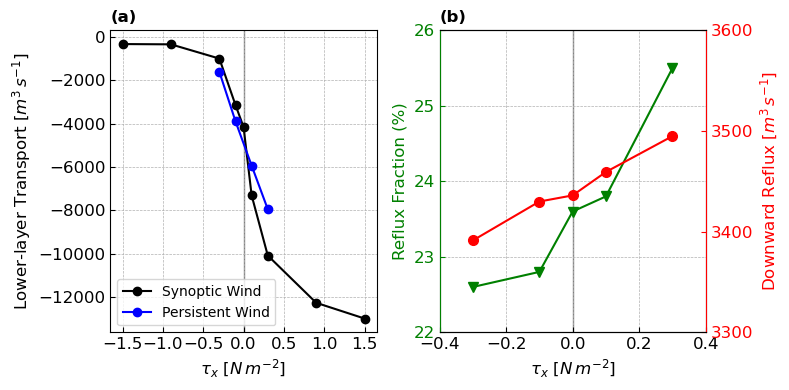

In [36]:
fig4 = plt.figure(figsize=(8,4), tight_layout=True)    

ax1 = fig4.add_subplot(122)
#plt.axis('square')
plt.grid(linestyle = '--', linewidth = 0.5)
#ax1.plot(taum,[alpha * 100 for alpha in alpha_w1],'v-g',ms=6,label=r'$\alpha_{11}$',zorder=2)
ax1.plot(taum_sub,[alpha * 100 for alpha in a11_sub],'v-g',ms=7,label=r'$\alpha_{11}$',zorder=2)
ax1.axvline(x=0, color='grey',ls='-',lw=1,zorder=1)
ax1.set(xlim=(-0.4, 0.4), ylim=(22,26))
#ax1.set(ylim=(20,28))
ax1.tick_params(direction='in', labelsize=12)
ax1.tick_params(axis='y', colors='green')

# ax1.set_xticks([-1.5,-1,-0.5,0,0.5,1,1.5])
ax1.set_xticks([-0.4,-0.2,0,0.2,0.4])
ax1.set_yticks([22,23,24,25,26])
ax1.set_xlabel(r"$\tau_x$ [$N\,m^{-2}$]",fontsize=12)
ax1.set_ylabel(r"Reflux Fraction (%)",fontsize=12,color='g')
ax1.set_title('(b)',loc='left', size=12, weight='bold')

ax2=ax1.twinx()
#ax2.plot(taum,Qr_w1,'o-r',ms=6,label=r'$Q_r$',zorder=2)
ax2.plot(taum_sub,Qr_new,'o-r',ms=7,label=r'$Q_r$',zorder=2)
#ax2.set(ylim=(3200,3800))
ax2.set(ylim=(3300,3600))
ax2.set_yticks([3300,3400,3500,3600])
ax2.tick_params(direction='in', labelsize=12)
ax2.spines['left'].set_color('green')
ax2.spines['right'].set_color('red')
ax2.tick_params(axis='y', colors='red')
ax2.set_ylabel(r"Downward Reflux $[m^3\,s^{-1}]$",fontsize=12,color='r')


ax3 = fig4.add_subplot(121)
plt.grid(linestyle = '--', linewidth = 0.5)
#ax1.plot(X,Ql,'s-',c='gray',ms=8,label=r'No Sill')
ax3.plot(taum,Qls,'o-',c='k',ms=6,label=r'Synoptic Wind')
ax3.plot([-0.3,-0.1,0.1,0.3],Ql_wind30,'o-',c='b',ms=6,label=r'Persistent Wind')
ax3.axvline(x=0, color='grey',ls='-',lw=1,zorder=1)
ax3.legend(loc='best', fontsize=10)
ax3.set_title('(a)',loc='left', size=12, weight='bold')
ax3.tick_params(direction='in', labelsize=12)
ax3.set_xticks([-1.5,-1,-0.5,0,0.5,1,1.5])
ax3.set_ylabel(r"Lower-layer Transport [$m^3\,s^{-1}$]",fontsize=12)
ax3.set_xlabel(r"$\tau_x$ [$N\,m^{-2}$]",fontsize=12)

In [37]:
fig_path ="/Users/weiyangbao/Documents/Figures/FjordModeling/JorgeMontt/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

#fig3.savefig(fig_path + 'Reflux.png', dpi=300, bbox_inches='tight')
fig4.savefig(fig_path + 'TransportFlux.png', dpi=300, bbox_inches='tight')